### Data Analysis of Itolizuma drug in Covid cases<a id='main'>

## Contents<a id='Contents'></a>
* [Data Analysis of Itolizuma drug in Covid cases](#main)
  * [Contents](#Contents)
    * [Import Libraries](#imports)
    * [Load Data](#load_data)
        * [Clean Data](#clean_data)
        * [Dummy encoding](#dummy_encoding)
        * [Fill NaN for weight column](#fillna)
        * [Plot histograms of each column](#plot_hist)
        * [Correlation map](#correlation_map)
        * [Train Test Split](#train_test_split)
        * [Imbalanced Data](#imbalanced_data)
        * [Baseline Modeling](#baseline_modeling)
        * [Train_test split](#train_test_split)
             
           
          * [Simple Forecast Methods](#simple_forecast_methods)
              * [Simple Exponential Smoothing Method](#simple_exponential_method)
          * [Baseline Modeling](#baseline_modeling) 
          * [Create Time Series Features](#create_ts_features)
          * [Create XGBoost Model](#create_xgb)
          * [feeature_importance](#feature_importance)
              
    * [Summary of Preprocessing](#summary)

### Import Libraries<a id='imports'>

In [1]:
%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score , plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#
print("Loaded Libraries")
import warnings
warnings.filterwarnings('ignore')

Loaded Libraries


### Load Data<a id='load_data'>

In [2]:
df = pd.read_csv('dockare_ml_covid_ards.csv', parse_dates=['admission_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   s_no               13 non-null     int64         
 1   admission_date     13 non-null     datetime64[ns]
 2   patient_num        13 non-null     object        
 3   age_yrs            13 non-null     int64         
 4   weight_kg          10 non-null     float64       
 5   gender             13 non-null     object        
 6   has_CT_scan        13 non-null     object        
 7   CT_scan_score      3 non-null      object        
 8   fever              4 non-null      object        
 9   vough              7 non-null      object        
 10  sob                13 non-null     object        
 11  weakness           7 non-null      object        
 12  appetite_loss      2 non-null      object        
 13  other_syptoms      4 non-null      object        
 14  diabetes_mil

In [3]:
df.head()

,s_no,admission_date,patient_num,age_yrs,weight_kg,gender,has_CT_scan,CT_scan_score,fever,vough,...,weakness,appetite_loss,other_syptoms,diabetes_millitus,hypertension,other_comorbidity,discharge_date,discharge_status,patient_death,target
0,1,2021-01-07,P1,58,75.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,Y,Y,NaN,Y \n27//1/2021,alive,N,0
1,2,2021-01-07,P2,84,76.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,NaN,Y,NaN,Y\n25-01-2021,alive\n(patient discharged on 3 ltr oxygen (RA)),N,0
2,3,2021-01-14,P3,53,75.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,Y\n08-02-2021,alive,N,0
3,4,2021-01-09,P4,69,95.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,Y\n23-01-2021,alive,N,0
4,5,2020-11-20,P5,77,65.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,Y,Y,NaN,12/10/2020,Dead,Y,1


In [4]:
#rename column names

df = df.rename(columns={'vough': 'cough', 'diabetes_millitus': 'diabetes_mellitus'})

In [5]:
df.head()

,s_no,admission_date,patient_num,age_yrs,weight_kg,gender,has_CT_scan,CT_scan_score,fever,cough,...,weakness,appetite_loss,other_syptoms,diabetes_mellitus,hypertension,other_comorbidity,discharge_date,discharge_status,patient_death,target
0,1,2021-01-07,P1,58,75.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,Y,Y,NaN,Y \n27//1/2021,alive,N,0
1,2,2021-01-07,P2,84,76.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,NaN,Y,NaN,Y\n25-01-2021,alive\n(patient discharged on 3 ltr oxygen (RA)),N,0
2,3,2021-01-14,P3,53,75.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,Y\n08-02-2021,alive,N,0
3,4,2021-01-09,P4,69,95.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,Y\n23-01-2021,alive,N,0
4,5,2020-11-20,P5,77,65.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,Y,Y,NaN,12/10/2020,Dead,Y,1


### Clean the data<a id='clean_data'>

In [6]:
df['discharge_date'].astype(str).str.replace(r".", "-", regex=False)

0     Y \n27//1/2021
1      Y\n25-01-2021
2      Y\n08-02-2021
3      Y\n23-01-2021
4         12/10/2020
5         12/10/2020
6         12/18/2020
7      Y\n12-11-2020
8       Y\n22/1/2021
9        Y\n4/3/2021
10      Y\n14/3/2021
11      Y\n14/4-2021
12     Y\n20-04-2021
Name: discharge_date, dtype: object

In [7]:
# Importing re package for using regular expressions
import re
  
# Function to clean the names
def Clean_names(date_column):
    # Search for opening bracket in the name followed by
    # any characters repeated any number of times
    if re.search('Y.*', date_column):
  
        # Extract the position of beginning of pattern
        pos = re.search('Y.*', date_column).start()
  
        # return the cleaned name
        return date_column[:pos]
  
    else:
        # if clean up needed return the same name
        return date_column
          
# Updated the city columns
df['discharge_date'] = df['discharge_date'].apply(Clean_names)
 

In [8]:
df.head(14)

,s_no,admission_date,patient_num,age_yrs,weight_kg,gender,has_CT_scan,CT_scan_score,fever,cough,...,weakness,appetite_loss,other_syptoms,diabetes_mellitus,hypertension,other_comorbidity,discharge_date,discharge_status,patient_death,target
0,1,2021-01-07,P1,58,75.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,Y,Y,NaN,,alive,N,0
1,2,2021-01-07,P2,84,76.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,NaN,Y,NaN,,alive\n(patient discharged on 3 ltr oxygen (RA)),N,0
2,3,2021-01-14,P3,53,75.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,,alive,N,0
3,4,2021-01-09,P4,69,95.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,,alive,N,0
4,5,2020-11-20,P5,77,65.0,M,Y,NaN,NaN,NaN,...,Y,NaN,NaN,Y,Y,NaN,12/10/2020,Dead,Y,1
5,6,2020-11-25,P6,68,72.0,M,Y,NaN,NaN,NaN,...,NaN,NaN,Body pain,NaN,NaN,NaN,12/10/2020,Alive\n(patient received 10 ltr oxygen at the ...,N,0
6,7,2020-11-19,P7,70,84.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,12/18/2020,Dead,Y,1
7,8,2020-11-06,P8,75,80.0,F,Y,NaN,NaN,Y,...,Y,NaN,NaN,Y,Y,NaN,,Alive \n(patient received 20 ltr of oxygen at ...,N,0
8,9,2020-12-29,P9,76,52.0,M,Y,NaN,NaN,Y,...,NaN,NaN,NaN,Y,Y,NaN,,Alive\n(Patient received 3 ltr oxyge at discha...,N,0
9,10,2021-02-24,P10,69,68.0,F,Y,NaN,Y,NaN,...,NaN,NaN,NaN,Y,Y,NaN,,Alive,N,0


In [9]:
df.columns

Index(['s_no', 'admission_date', 'patient_num', 'age_yrs', 'weight_kg',
       'gender', 'has_CT_scan', 'CT_scan_score', 'fever', 'cough', 'sob',
       'weakness', 'appetite_loss', 'other_syptoms', 'diabetes_mellitus',
       'hypertension', 'other_comorbidity', 'discharge_date',
       'discharge_status', 'patient_death', 'target'],
      dtype='object')

### Dummy encoding<a id='dummy_encoding'>

In [10]:
categorical_features = ['gender', 'has_CT_scan','fever', 'cough', 
       'weakness', 'appetite_loss', 'diabetes_mellitus',
       'hypertension', 'patient_death']
df = pd.get_dummies(df, columns = categorical_features)
print('The data have ', df.shape[0], ' rows and ', df.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df.columns)))


The data have  13  rows and  23  columns

column names: 

s_no
admission_date
patient_num
age_yrs
weight_kg
CT_scan_score
sob
other_syptoms
other_comorbidity
discharge_date
discharge_status
target
gender_F
gender_M
has_CT_scan_Y
fever_Y
cough_Y
weakness_Y
appetite_loss_Y
diabetes_mellitus_Y
hypertension_Y
patient_death_N
patient_death_Y


In [11]:
df.head(15)

,s_no,admission_date,patient_num,age_yrs,weight_kg,CT_scan_score,sob,other_syptoms,other_comorbidity,discharge_date,...,gender_M,has_CT_scan_Y,fever_Y,cough_Y,weakness_Y,appetite_loss_Y,diabetes_mellitus_Y,hypertension_Y,patient_death_N,patient_death_Y
0,1,2021-01-07,P1,58,75.0,NaN,Y,NaN,NaN,,...,1,1,0,0,1,0,1,1,1,0
1,2,2021-01-07,P2,84,76.0,NaN,Y - GRADE 4,NaN,NaN,,...,1,1,0,0,1,0,0,1,1,0
2,3,2021-01-14,P3,53,75.0,NaN,Y - GRADE 4,NaN,NaN,,...,1,1,0,1,0,0,1,1,1,0
3,4,2021-01-09,P4,69,95.0,NaN,Y - GRADE 4,NaN,NaN,,...,1,1,0,1,0,0,1,1,1,0
4,5,2020-11-20,P5,77,65.0,NaN,Y - GRADE 4,NaN,NaN,12/10/2020,...,1,1,0,0,1,0,1,1,0,1
5,6,2020-11-25,P6,68,72.0,NaN,Y - GRADE 4,Body pain,NaN,12/10/2020,...,1,1,0,0,0,0,0,0,1,0
6,7,2020-11-19,P7,70,84.0,NaN,Y - GRADE 4,NaN,NaN,12/18/2020,...,1,1,0,1,0,0,1,1,0,1
7,8,2020-11-06,P8,75,80.0,NaN,Y,NaN,NaN,,...,0,1,0,1,1,0,1,1,1,0
8,9,2020-12-29,P9,76,52.0,NaN,Y,NaN,NaN,,...,1,1,0,1,0,0,1,1,1,0
9,10,2021-02-24,P10,69,68.0,NaN,Y - GRADE 4,NaN,NaN,,...,0,1,1,0,0,0,1,1,1,0


In [12]:
df.loc[df['sob'] == 'Y - GRADE 4', 'sob'] = 'Y'

In [13]:
df = pd.get_dummies(df, columns = ['sob'])

In [14]:
df.head()

,s_no,admission_date,patient_num,age_yrs,weight_kg,CT_scan_score,other_syptoms,other_comorbidity,discharge_date,discharge_status,...,has_CT_scan_Y,fever_Y,cough_Y,weakness_Y,appetite_loss_Y,diabetes_mellitus_Y,hypertension_Y,patient_death_N,patient_death_Y,sob_Y
0,1,2021-01-07,P1,58,75.0,NaN,NaN,NaN,,alive,...,1,0,0,1,0,1,1,1,0,1
1,2,2021-01-07,P2,84,76.0,NaN,NaN,NaN,,alive\n(patient discharged on 3 ltr oxygen (RA)),...,1,0,0,1,0,0,1,1,0,1
2,3,2021-01-14,P3,53,75.0,NaN,NaN,NaN,,alive,...,1,0,1,0,0,1,1,1,0,1
3,4,2021-01-09,P4,69,95.0,NaN,NaN,NaN,,alive,...,1,0,1,0,0,1,1,1,0,1
4,5,2020-11-20,P5,77,65.0,NaN,NaN,NaN,12/10/2020,Dead,...,1,0,0,1,0,1,1,0,1,1


In [15]:
df.columns

Index(['s_no', 'admission_date', 'patient_num', 'age_yrs', 'weight_kg',
       'CT_scan_score', 'other_syptoms', 'other_comorbidity', 'discharge_date',
       'discharge_status', 'target', 'gender_F', 'gender_M', 'has_CT_scan_Y',
       'fever_Y', 'cough_Y', 'weakness_Y', 'appetite_loss_Y',
       'diabetes_mellitus_Y', 'hypertension_Y', 'patient_death_N',
       'patient_death_Y', 'sob_Y'],
      dtype='object')

In [16]:
df_log = df[['age_yrs', 'weight_kg','gender_F', 'gender_M', 'has_CT_scan_Y',
       'fever_Y', 'cough_Y', 'weakness_Y', 'appetite_loss_Y',
       'diabetes_mellitus_Y', 'hypertension_Y', 'sob_Y', 'target']]

In [17]:
df_log.head(15)

,age_yrs,weight_kg,gender_F,gender_M,has_CT_scan_Y,fever_Y,cough_Y,weakness_Y,appetite_loss_Y,diabetes_mellitus_Y,hypertension_Y,sob_Y,target
0,58,75.0,0,1,1,0,0,1,0,1,1,1,0
1,84,76.0,0,1,1,0,0,1,0,0,1,1,0
2,53,75.0,0,1,1,0,1,0,0,1,1,1,0
3,69,95.0,0,1,1,0,1,0,0,1,1,1,0
4,77,65.0,0,1,1,0,0,1,0,1,1,1,1
5,68,72.0,0,1,1,0,0,0,0,0,0,1,0
6,70,84.0,0,1,1,0,1,0,0,1,1,1,1
7,75,80.0,1,0,1,0,1,1,0,1,1,1,0
8,76,52.0,0,1,1,0,1,0,0,1,1,1,0
9,69,68.0,1,0,1,1,0,0,0,1,1,1,0


In [18]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_yrs              13 non-null     int64  
 1   weight_kg            10 non-null     float64
 2   gender_F             13 non-null     uint8  
 3   gender_M             13 non-null     uint8  
 4   has_CT_scan_Y        13 non-null     uint8  
 5   fever_Y              13 non-null     uint8  
 6   cough_Y              13 non-null     uint8  
 7   weakness_Y           13 non-null     uint8  
 8   appetite_loss_Y      13 non-null     uint8  
 9   diabetes_mellitus_Y  13 non-null     uint8  
 10  hypertension_Y       13 non-null     uint8  
 11  sob_Y                13 non-null     uint8  
 12  target               13 non-null     int64  
dtypes: float64(1), int64(2), uint8(10)
memory usage: 570.0 bytes


### Fill NaN for weight column<a id='fillna'>

In [19]:
# since weigth column as three NaNs I will replace those with mean weights

df_log['weight_kg'].fillna(df_log['weight_kg'].mean(), inplace = True)


In [20]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_yrs              13 non-null     int64  
 1   weight_kg            13 non-null     float64
 2   gender_F             13 non-null     uint8  
 3   gender_M             13 non-null     uint8  
 4   has_CT_scan_Y        13 non-null     uint8  
 5   fever_Y              13 non-null     uint8  
 6   cough_Y              13 non-null     uint8  
 7   weakness_Y           13 non-null     uint8  
 8   appetite_loss_Y      13 non-null     uint8  
 9   diabetes_mellitus_Y  13 non-null     uint8  
 10  hypertension_Y       13 non-null     uint8  
 11  sob_Y                13 non-null     uint8  
 12  target               13 non-null     int64  
dtypes: float64(1), int64(2), uint8(10)
memory usage: 570.0 bytes


In [21]:
class_counts = df_log['target'].value_counts()
class_counts

0    11
1     2
Name: target, dtype: int64

In [22]:
type(class_counts)

pandas.core.series.Series

In [23]:
class_percentages = pd.Series([(x / df_log.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    84.615385
1    15.384615
dtype: float64

### Plot histograms of each column<a id='plot_hist'>

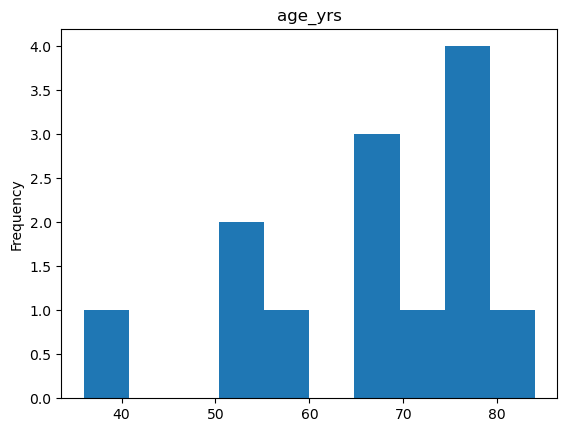

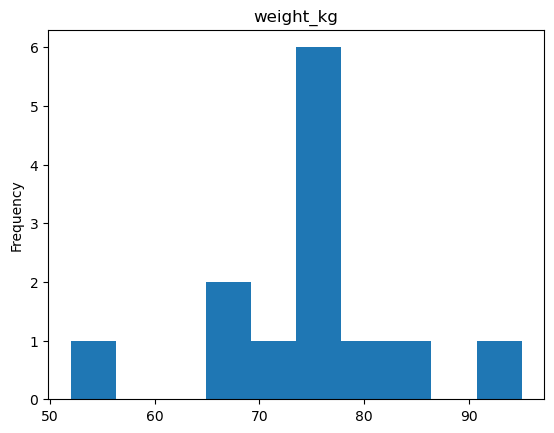

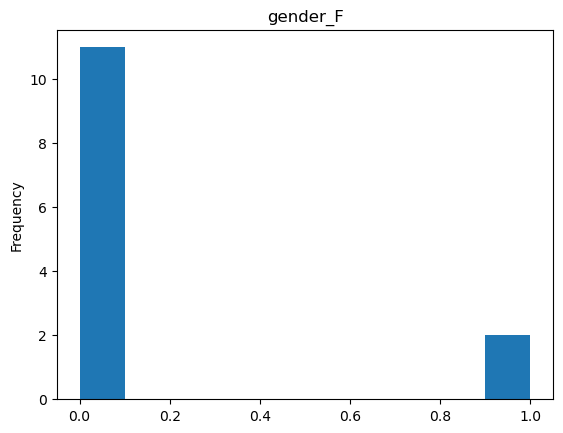

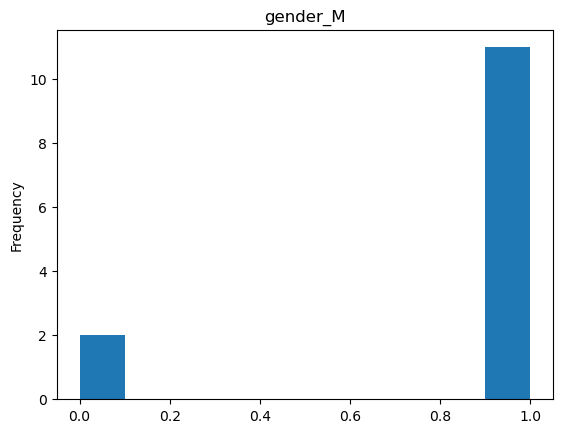

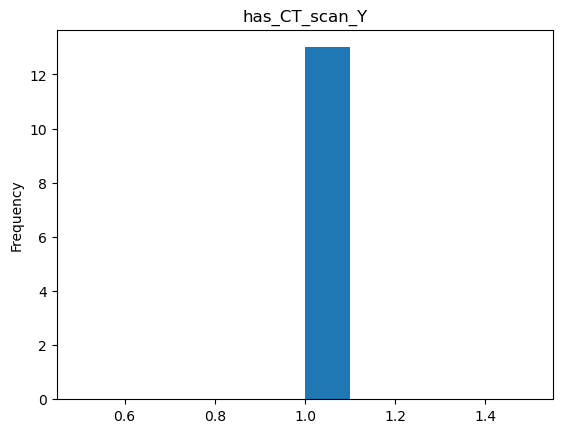

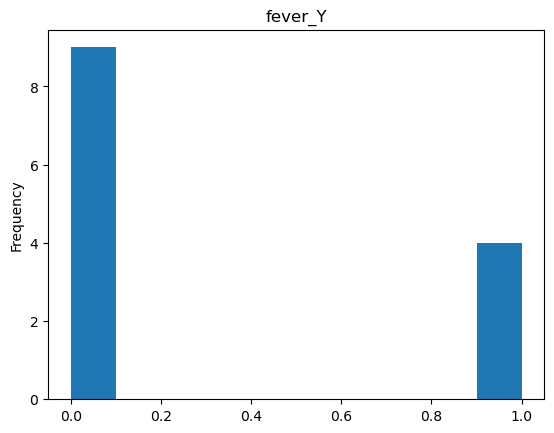

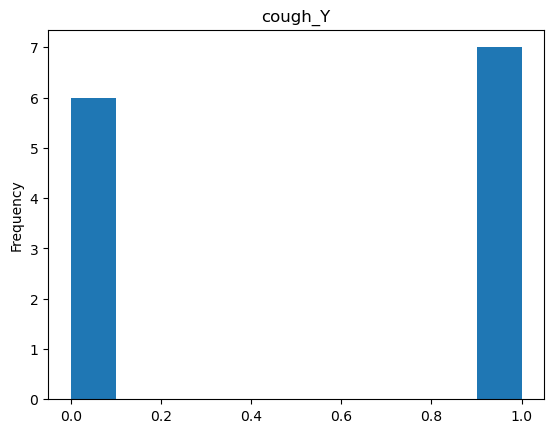

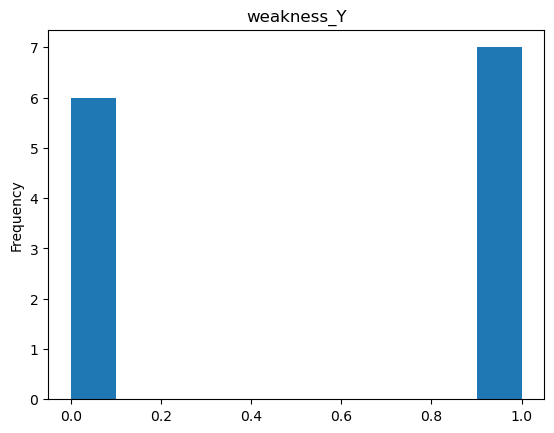

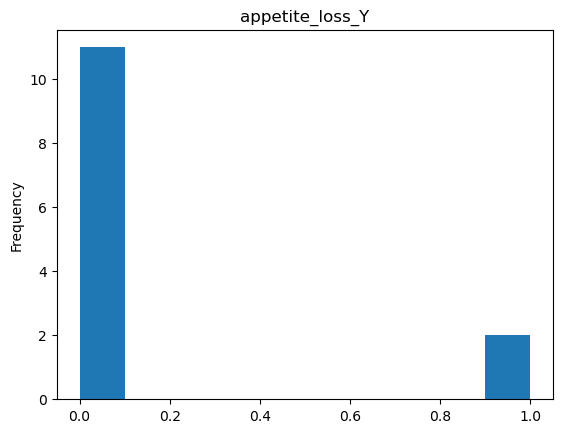

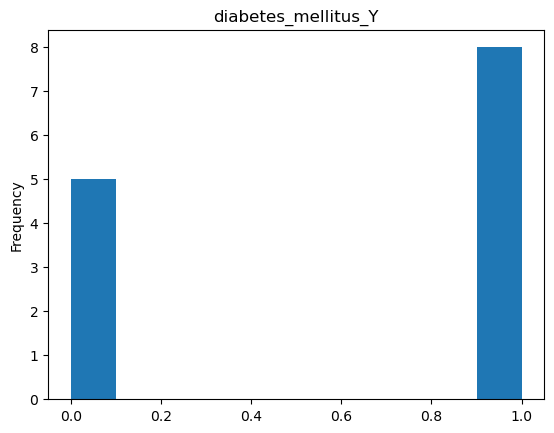

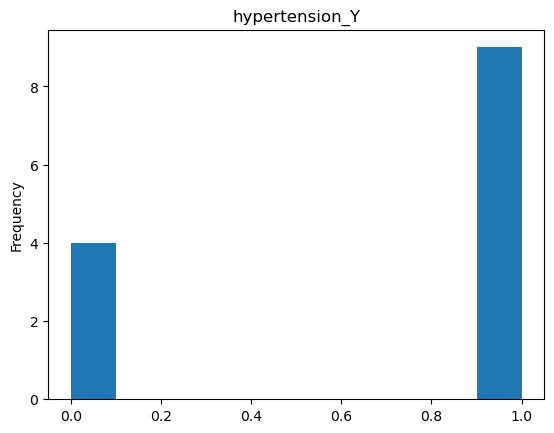

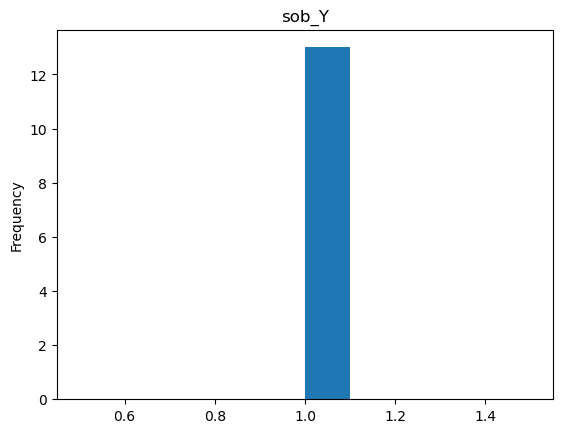

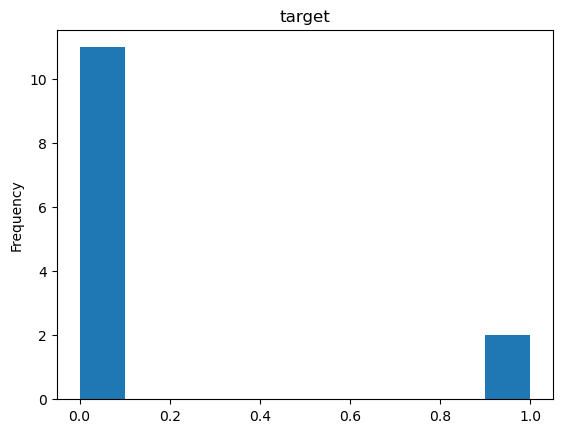

In [24]:
for col in list(df_log.columns):
    df_log[col].plot(kind = 'hist', title = col)
    plt.show()

### Correlation map<a id='correlation_map'>

Correlation between various features


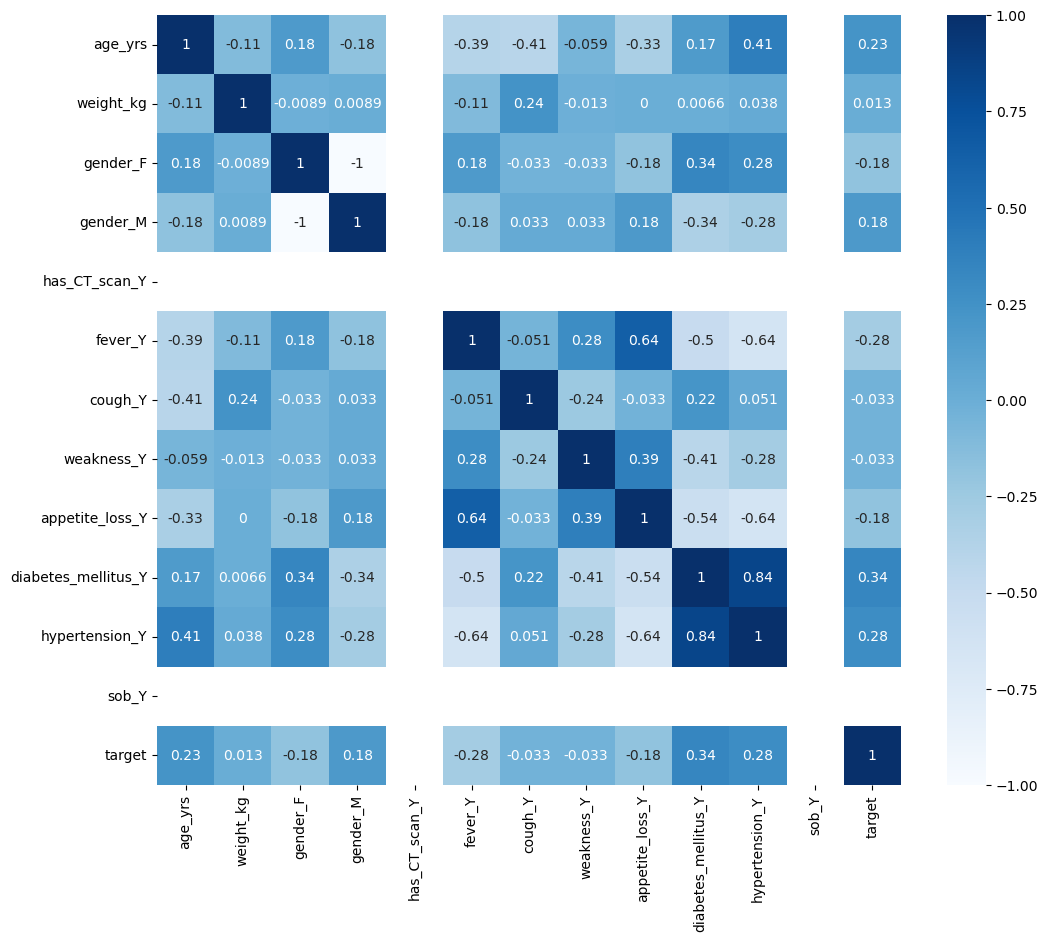

In [25]:
plt.figure(figsize=(12,10))
print('Correlation between various features')
p=sns.heatmap(df_log.corr(), annot=True,cmap ='Blues')

### Train Test Split<a id='train_test_split'>

In [26]:
X = df_log.drop('target' , axis=1)
y = df_log['target']

In [27]:
X_train, X_test, y_train, y_test = train_test_split (X , y , test_size=0.25 , random_state=11)

In [28]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((9, 12), (4, 12), (9,), (4,))

### Imbalanced Data<a id='imbalanced_data'>

In [29]:
def plot_y_ratios(y, ytest):
    fig, ax = plt.subplots(2, sharex = True)
    ax[0].bar(x = [0, 1], height = [y[y == 0].count(), 
                                    y[y == 1].count()])
    ax[0].set_ylabel('train', fontsize = 8)
    ax[0].set_ylim(0, 125)
    ax[1].bar(x = [0, 1], height = [ytest[ytest == 0].count(),
                                    ytest[ytest == 1].count()])
    ax[1].set_ylabel('test', fontsize = 8)
    ax[1].set_ylim(0, 125)
    ax[1].set_xticks([0, 1])
    ax[0].tick_params(which = 'both', labelsize = 8)
    ax[1].tick_params(which = 'both', labelsize = 8)
    ax[1].set_xlabel('covid deaths\n(0 = alive)', fontsize = 8)
    ax[0].set_title('% Covid deaths (where 1 means death):\n' +
                    'train: ' + str(round(100 * (y[y ==1].count()/y.shape[0]), 0)) +
                    '\ntest: ' + str(round(100 * (ytest[ytest ==1].count()/ytest.shape[0]), 0)),
                   fontsize = 10)
    plt.show() 

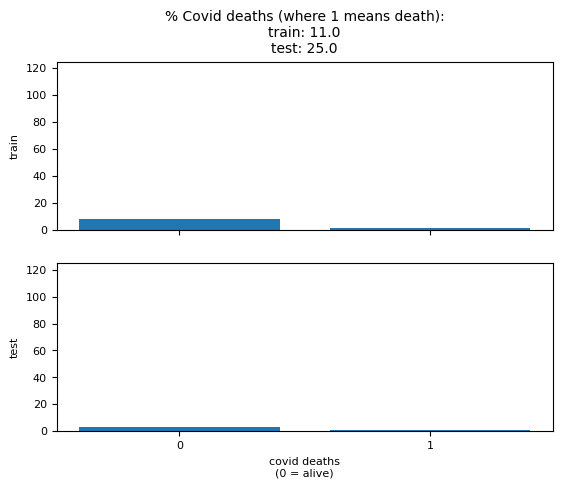

In [30]:
plot_y_ratios(y_train, y_test)

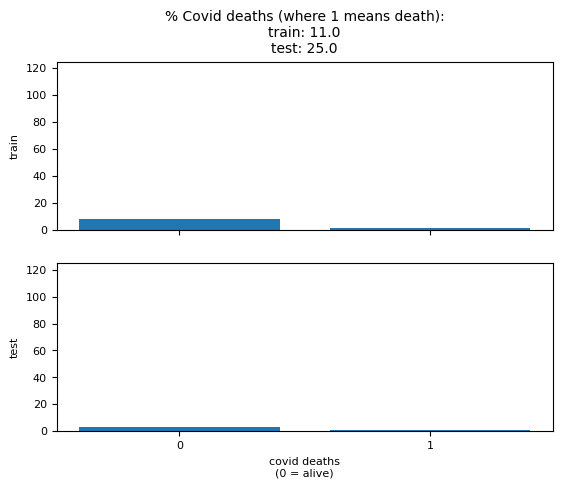

In [31]:
X_train, X_test, y_train, y_test = train_test_split (X , y ,stratify = y,  test_size=0.25, random_state=2)
plot_y_ratios(y_train, y_test)

### Scale the data

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

In [34]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
X_train

array([[ 0.75295722,  0.55009329,  1.87082869, -1.87082869,  0.        ,
        -0.53452248,  1.11803399,  0.89442719,  0.        ,  0.70710678,
         0.53452248,  0.        ],
       [-1.43947705, -0.07187148, -0.53452248,  0.53452248,  0.        ,
        -0.53452248,  1.11803399, -1.11803399,  0.        ,  0.70710678,
         0.53452248,  0.        ],
       [ 1.64986215,  0.05252147, -0.53452248,  0.53452248,  0.        ,
        -0.53452248, -0.89442719,  0.89442719,  0.        , -1.41421356,
         0.53452248,  0.        ],
       [ 0.0553645 , -0.44505035, -0.53452248,  0.53452248,  0.        ,
        -0.53452248, -0.89442719, -1.11803399,  0.        , -1.41421356,
        -1.87082869,  0.        ],
       [ 0.95226943, -1.31580102, -0.53452248,  0.53452248,  0.        ,
        -0.53452248, -0.89442719,  0.89442719,  0.        ,  0.70710678,
         0.53452248,  0.        ],
       [-0.94119653, -0.07187148, -0.53452248,  0.53452248,  0.        ,
        -0.53452248, -

### Baseline Modeling<a id='baseline_modeling'>

In [36]:
logreg = LogisticRegression(solver = 'newton-cg')

In [37]:
logreg.fit(X_train , y_train)

LogisticRegression(solver='newton-cg')

In [38]:
y_pred = logreg.predict(X_test)

In [39]:
y_pred_train = logreg.predict(X_train)

In [40]:
from sklearn.metrics import classification_report , plot_roc_curve , accuracy_score , plot_confusion_matrix

In [41]:
print("[Test] Accuracy score: (y_test, y_pred)", 
      f'{accuracy_score(y_test, y_pred):.2f}')

[Test] Accuracy score: (y_test, y_pred) 0.75


In [42]:
print('The f1 score for the model model is:',f1_score(y_test, y_pred))

The f1 score for the model model is: 0.0


###  f1 score is zero which indicates that the model is performing poorly on the minority class.

In [43]:
logreg.classes_

array([0, 1], dtype=int64)

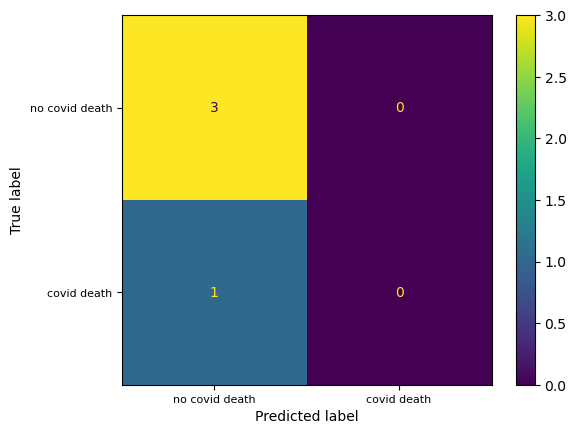

In [44]:
cm = confusion_matrix(y_test, y_pred, labels = logreg.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no covid death', 'covid death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no covid death', 'covid death'], fontsize = 8)
ax.set_yticklabels(labels = ['no covid death', 'covid death'], fontsize = 8)
display_cm.plot(ax = ax)

In [45]:
print("[Training Classification Report]")
print(classification_report(y_train, y_pred_train))
#
print("[Test Classification Report]")
print(classification_report(y_test, y_pred))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



### LogisticRegression with class_weight parameter to balance the data<a id='class_weight'>

In [188]:
logreg = LogisticRegression(solver = 'newton-cg', class_weight={0: 0.043889, 1: 0.95611})
logreg.fit(X_train , y_train)
y_pred = logreg.predict(X_test)

In [189]:
print("[Test] Accuracy score: (y_test, y_pred)", 
      f'{accuracy_score(y_test, y_pred):.2f}')


[Test] Accuracy score: (y_test, y_pred) 0.50


In [190]:
print('The f1 score for the model model is:',f1_score(y_test, y_pred))

The f1 score for the model model is: 0.5


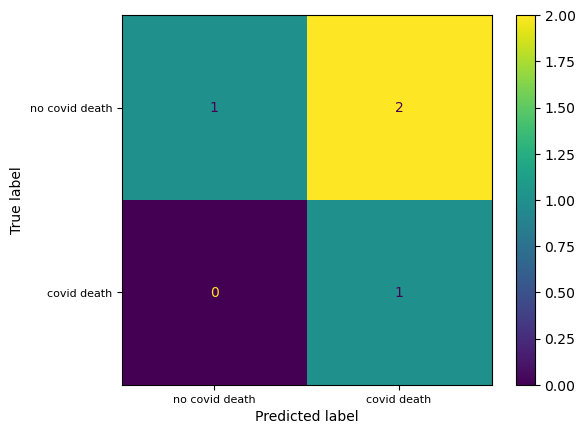

In [77]:
cm = confusion_matrix(y_test, y_pred, labels = logreg.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no covid death', 'covid death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no covid death', 'covid death'], fontsize = 8)
ax.set_yticklabels(labels = ['no covid death', 'covid death'], fontsize = 8)
display_cm.plot(ax = ax)

In [78]:
print("[Training Classification Report]")
print(classification_report(y_train, y_pred_train))
#
print("[Test Classification Report]")
print(classification_report(y_test, y_pred))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.33      1.00      0.50         1

    accuracy                           0.50         4
   macro avg       0.67      0.67      0.50         4
weighted avg       0.83      0.50      0.50         4



### Summary<a id-='summary'>

* Data is a highly imbalanced and used some hyperparameter tuning on the algorithm to improve the f1 evaluation metric. 
* Accuracy is compromised when we tried to balance the weights of the minoirty class. 
* False positives got increased due to twea 